In [1]:
# standard library imports
import csv
import ast
import datetime as dt
import json
import os
import statistics
import time

import matplotlib.pyplot as plt
import seaborn as sns
# third-party imports
import numpy as np
import pandas as pd

import requests
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
import sklearn.cluster as cluster
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/Users/longn/CodeStuffs/Kaggle/Store Prediction/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
np.random.seed(0)

In [34]:
holidays_events = pd.read_csv('holidays_events.csv')
# trainning_data = pd.read_csv('train.csv')
# test_data = pd.read_csv('test.csv')
stores_data = pd.read_csv('stores.csv')
transaction_data = pd.read_csv('transactions.csv')
oil_data = pd.read_csv('oil.csv')

In [35]:
features = ['store_nbr','onpromotion']

In [3]:
store_sales = pd.concat([x for x in pd.read_csv('train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    chunksize=1000
)], ignore_index=True)

In [4]:
store_sales.describe()

,date,sales,onpromotion
count,3000888,3.000888e+06,3.000888e+06
mean,2015-04-24 08:27:04.703088384,3.577758e+02,2.602770e+00
min,2013-01-01 00:00:00,0.000000e+00,0.000000e+00
25%,2014-02-26 18:00:00,0.000000e+00,0.000000e+00
50%,2015-04-24 12:00:00,1.100000e+01,0.000000e+00
75%,2016-06-19 06:00:00,1.958473e+02,0.000000e+00
max,2017-08-15 00:00:00,1.247170e+05,7.410000e+02
std,NaN,1.101998e+03,1.221888e+01


In [7]:
# Sort based on family
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

In [16]:
store_sales

sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000          0.0
                     2013-01-02   2.000000          0.0
                     2013-01-03   3.000000          0.0
                     2013-01-04   3.000000          0.0
                     2013-01-05   5.000000          0.0
...                                    ...          ...
9         SEAFOOD    2013-02-10  11.000000          0.0
                     2013-02-11  13.000000          0.0
                     2013-02-12   9.000000          0.0
                     2013-02-13  14.096001          0.0
                     2013-02-14  25.806000          0.0

[81886 rows x 2 columns]

In [8]:
print(f'\nYear In Sales: 2017')

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc["2017"]
)


Year In Sales: 2017


/var/folders/lv/7cyrsyg90zs3cbgcjkk9mvsr0000gn/T/ipykernel_99416/3184806821.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  store_sales


In [18]:
family_sales.head(5)

sales                                              \
family     AUTOMOTIVE BABY CARE     BEAUTY    BEVERAGES     BOOKS   
date                                                                
2017-01-01   0.092593  0.037037   0.055556    74.222221  0.000000   
2017-01-02  11.481482  0.259259  11.648149  6208.055664  0.481481   
2017-01-03   8.296296  0.296296   7.185185  4507.814941  0.814815   
2017-01-04   6.833333  0.333333   6.888889  3911.833252  0.759259   
2017-01-05   6.333333  0.351852   5.925926  3258.796387  0.407407   

                                                                           \
family     BREAD/BAKERY CELEBRATION     CLEANING        DAIRY        DELI   
date                                                                        
2017-01-01     9.084685    0.129630     7.500000    11.518518    3.629167   
2017-01-02   844.836304   14.203704  2233.648193  1545.000000  539.114807   
2017-01-03   665.124146   10.629630  1711.907349  1204.203735  404.300049   
2017-01-04   594.160645   11.185185  1508.036987  1107.796265  309.397675   
2017-01-05   495.511597   12.444445  1241.833374   829.277771  260.776489   

            ... onpromotion                                       \
family      ...   MAGAZINES     MEATS PERSONAL CARE PET SUPPLIES   
date        ...                                                    
2017-01-01  ...         0.0  0.018519      0.111111     0.018519   
2017-01-02  ...         0.0  0.462963     10.592593     0.537037   
2017-01-03  ...         0.0  0.481481      9.722222     0.444444   
2017-01-04  ...         0.0  0.370370     12.037037     0.444444   
2017-01-05  ...         0.0  8.981481      5.666667     0.000000   

                                                                         \
family     PLAYERS AND ELECTRONICS   POULTRY PREPARED FOODS     PRODUCE   
date                                                                      
2017-01-01                     0.0  0.000000       0.037037    0.129630   
2017-01-02                     0.0  0.259259       1.166667    5.629630   
2017-01-03                     0.0  0.388889       1.351852   56.296296   
2017-01-04                     0.0  0.296296       5.444444  101.277778   
2017-01-05                     0.0  0.296296       0.907407    5.018519   

                                                 
family     SCHOOL AND OFFICE SUPPLIES   SEAFOOD  
date                                             
2017-01-01                        0.0  0.000000  
2017-01-02                        0.0  0.407407  
2017-01-03                        0.0  0.407407  
2017-01-04                        0.0  0.333333  
2017-01-05                        0.0  0.444444  

[5 rows x 66 columns]

In [21]:
# test = pd.read_csv(
#     'test.csv',
#     dtype={
#         'store_nbr': 'category',
#         'family': 'category',
#         'onpromotion': 'uint32',
#     },
#     parse_dates=['date'],
    
# )

test = pd.concat([x for x in pd.read_csv('test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    chunksize=1000

)], ignore_index=True)
step_count = len(set(test['date'].unique()))
test['date'] = test.date.dt.to_period('D')

# step_count
# dir(step_count)
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [22]:
test

id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08-17  3002670            0
                     2017-08-18  3004452            0
                     2017-08-19  3006234            0
                     2017-08-20  3008016            0
...                                  ...          ...
9         SEAFOOD    2017-08-27  3022271            0
                     2017-08-28  3024053            0
                     2017-08-29  3025835            0
                     2017-08-30  3027617            0
                     2017-08-31  3029399            0

[28512 rows x 2 columns]

<h2> Step 2: Determining Lag </h2>

In [25]:
store_sales_lag = pd.concat([x for x in pd.read_csv('train.csv',
                                   usecols=['sales'],
    dtype={
        'sales': 'float32',
    },
    # parse_dates=['date'],
    chunksize=1000

)], ignore_index=True)

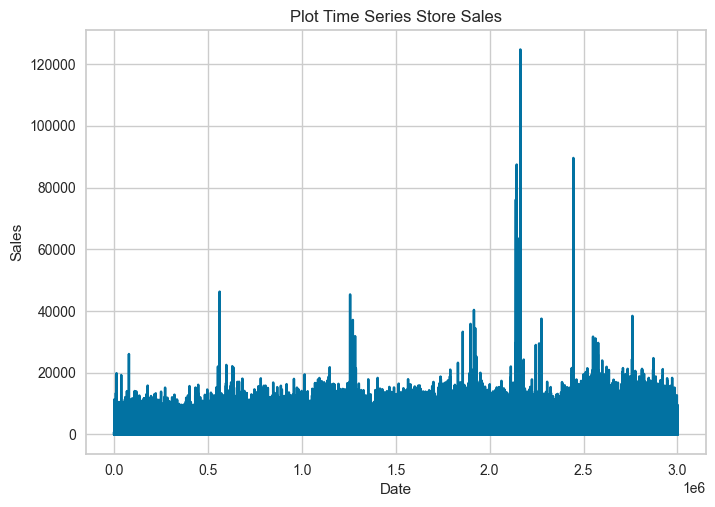

In [26]:
plt.plot(store_sales_lag)
plt.title("Plot Time Series Store Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ACF plot (autocorrelation)
plot_acf(store_sales_lag, ax=axes[0], lags=20)
axes[0].set_title('ACF Plot')

# PACF plot (partial autocorrelation)
plot_pacf(store_sales_lag, ax=axes[1], lags=20, method='ywm')
axes[1].set_title('PACF Plot')

plt.show()

In [126]:
# Function to fit ARIMA models with different p (lags) and return AIC scores
def select_best_lag(time_series, max_lag):
    aic_values = []

    for p in range(1, max_lag + 1):
        model = ARIMA(time_series, order=(p, 0, 0))  # ARIMA(p, d, q) where d=0 for AR model
        model_fit = model.fit()
        aic_values.append((p, model_fit.aic))

    return aic_values

# Set max_lag to try and get the best lag based on AIC
max_lag = 10
aic_scores = select_best_lag(store_sales_lag, max_lag)

# Print the AIC values for different lags
for lag, aic in aic_scores:
    print(f'Lag: {lag}, AIC: {aic}')

# Find the lag with the minimum AIC value
best_lag = min(aic_scores, key=lambda x: x[1])[0]
print(f'\nOptimal Lag based on AIC: {best_lag}')

Lag: 1, AIC: 1292807.6624771259
Lag: 2, AIC: 1292539.0868848793
Lag: 3, AIC: 1292532.0280505298
Lag: 4, AIC: 1290634.1065865369
Lag: 5, AIC: 1285901.3787977176
Lag: 6, AIC: 1285523.1644179907
Lag: 7, AIC: 1285518.6329086635
Lag: 8, AIC: 1285070.23798433
Lag: 9, AIC: 1282555.9901864745
Lag: 10, AIC: 1281830.887272493

Optimal Lag based on AIC: 10


<h2>Step 3: Predict</h3>


In [11]:
best_lag = 16
step_count = 1

In [9]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)

def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)



def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [12]:
y = family_sales.loc[:, 'sales']

X = make_lags(y,lags=best_lag).dropna()

print(f'\nStep Count {step_count} with {best_lag} lags')

y = make_multistep_target(y, steps=step_count).dropna()

y, X = y.align(X, join='inner', axis=0)



Step Count 1 with 16 lags


In [13]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y)

/var/folders/lv/7cyrsyg90zs3cbgcjkk9mvsr0000gn/T/ipykernel_99416/3444948386.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  X = (X
/var/folders/lv/7cyrsyg90zs3cbgcjkk9mvsr0000gn/T/ipykernel_99416/3444948386.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  y = y.stack('family')  # wide to long


y_step_1
date       family                                 
2017-01-17 AUTOMOTIVE                     5.685185
           BABY CARE                      0.166667
           BEAUTY                         5.351852
           BEVERAGES                   3409.796387
           BOOKS                          0.500000
...                                            ...
2017-08-15 POULTRY                      325.679840
           PREPARED FOODS                85.954132
           PRODUCE                     2316.832764
           SCHOOL AND OFFICE SUPPLIES    46.851852
           SEAFOOD                       17.966240

[6963 rows x 1 columns]

<h3>Step 4: Model Prediction<h3>

In [14]:
model = RegressorChain(base_estimator=XGBRegressor())

model

RegressorChain(base_estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...))

In [ ]:
model.fit(X, y)

y_pred = pd.DataFrame(
    model.predict(X),
    index=y.index,
    columns=y.columns,
).clip(0.0)


y_step_1
date       family                                 
2017-01-17 AUTOMOTIVE                     6.495348
           BABY CARE                      0.699098
           BEAUTY                         6.495348
           BEVERAGES                   3422.130371
           BOOKS                          0.787698
...                                            ...
2017-08-15 POULTRY                      323.414825
           PREPARED FOODS                89.961288
           PRODUCE                     2350.586914
           SCHOOL AND OFFICE SUPPLIES    58.642517
           SEAFOOD                       20.505081

[6963 rows x 1 columns]

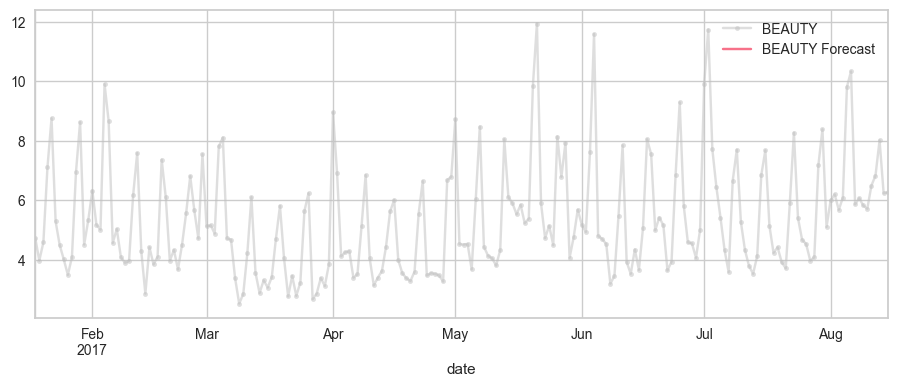

In [21]:
FAMILY = 'BEAUTY'
START = '2017-01-18'
EVERY = 16
plot_params = {"color": "0.75", "style":".-"}

y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

y_pred.xs(FAMILY, level='family', axis=0)

fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
_ = ax.legend([FAMILY, FAMILY + ' Forecast'])